In [1]:
import mxnet as mx
from mxnet import image, gluon, autograd
from mxnet.gluon.data.vision import transforms
import gluoncv as gcv
from gluoncv import model_zoo, data, utils

from pylab import rcParams
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
import ast
import time

rcParams['figure.figsize'] = 15, 15

In [2]:
class WheatDataset(gluon.data.Dataset):
    def __init__(self, root="/kaggle/input/global-wheat-detection", transforms=None, data_ids=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        #----self.imgs = list(sorted(os.listdir(os.path.join(root, "train"))))
        
        
        # Attention: some images may not be listed in the csv data as they
        # have no wheat heads.
        # data of wheat with heads:
        df = pd.read_csv(os.path.join(root, "train.csv"),
                        converters={"bbox":ast.literal_eval})
        self.data = df.groupby("image_id").apply(self.getinfo) #.sample(frac=.9, random_state=1)
        """data1 = df.groupby("image_id").apply(self.getinfo)
        data2 = data1[data1['box_count']>100]
        self.data = pd.concat([data2, data1])"""
        
        self.imgs_with_heads = set(self.data.index) # the search in a set is faster
        #self.imgs = self.data.index
        if data_ids is None:
            #np.random.choice(self.data.index, len(df)-)
            self.imgs = self.data.index
        else:
            self.imgs = self.data.index[data_ids]

    def getinfo(self, image_info):
        box_count = image_info.shape[0]
        bboxes = np.array(image_info["bbox"].to_list())
        bboxes[:,2] += bboxes[:,0]
        bboxes[:,3] += bboxes[:,1]

        # If func returns a Series object the result will be a DataFrame.
        return pd.Series([box_count, bboxes],
                         index=['box_count', 'bboxes'])

    def __getitem__(self, idx):
        # load images
        img_filename = self.imgs[idx]+".jpg"
        # remove extension for img id
        img_id = img_filename[:-4]

        img_path = os.path.join(self.root, "train", img_filename)
        img = image.imread(img_path)

        if img_id in self.imgs_with_heads:
            img_info = self.data.loc[img_id]
            box_count = img_info["box_count"]
            bboxes = img_info["bboxes"]
        else:
            box_count = 0
            bboxes = np.array([]).reshape(-1, 4)
        
        cls_labels = np.zeros([1,box_count])
        target = np.concatenate((bboxes, cls_labels.T), axis=1)
        ##target = mx.nd.array(target)
        
        #bboxes = mx.nd.array(bboxes)
        #cls_labels = mx.nd.array(cls_labels)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
train_dataset = WheatDataset()
len(train_dataset), train_dataset[0][0].shape, train_dataset[0][1].shape

(3373, (1024, 1024, 3), (55, 5))

In [4]:
"""train_image, train_label = train_dataset[8]
bboxes = train_label[:, :4]
cids = train_label[:, 4:5]
print('image:', train_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)

from matplotlib import pyplot as plt
from gluoncv.utils import viz

ax = viz.plot_bbox(train_image.asnumpy(), bboxes, labels=cids, class_names=["wheat"])
plt.show()"""

'train_image, train_label = train_dataset[8]\nbboxes = train_label[:, :4]\ncids = train_label[:, 4:5]\nprint(\'image:\', train_image.shape)\nprint(\'bboxes:\', bboxes.shape, \'class ids:\', cids.shape)\n\nfrom matplotlib import pyplot as plt\nfrom gluoncv.utils import viz\n\nax = viz.plot_bbox(train_image.asnumpy(), bboxes, labels=cids, class_names=["wheat"])\nplt.show()'

In [5]:
def faster_rcnn_fpn_resnet101_v1d_coco(pretrained=False, pretrained_base=True, **kwargs):
    r"""Faster RCNN model with FPN from the paper
    "Ren, S., He, K., Girshick, R., & Sun, J. (2015). Faster r-cnn: Towards
    real-time object detection with region proposal networks"
    "Lin, T., Dollar, P., Girshick, R., He, K., Hariharan, B., Belongie, S. (2016).
    Feature Pyramid Networks for Object Detection"
    Parameters
    ----------
    pretrained : bool or str
        Boolean value controls whether to load the default pretrained weights for model.
        String value represents the hashtag for a certain version of pretrained weights.
    pretrained_base : bool or str, optional, default is True
        Load pretrained base network, the extra layers are randomized. Note that
        if pretrained is `Ture`, this has no effect.
    ctx : Context, default CPU
        The context in which to load the pretrained weights.
    root : str, default '~/.mxnet/models'
        Location for keeping the model parameters.
    Examples
    --------
    >>> model = get_faster_rcnn_fpn_resnet101_v1d_coco(pretrained=True)
    >>> print(model)
    """
    from gluoncv.nn.feature import FPNFeatureExpander
    from gluoncv.model_zoo.resnetv1b import resnet101_v1d
    from gluoncv.data import COCODetection
    from mxnet.gluon import nn
    from gluoncv.model_zoo.rcnn.faster_rcnn.faster_rcnn import get_faster_rcnn
    
    classes = COCODetection.CLASSES
    pretrained_base = False if pretrained else pretrained_base
    base_network = resnet101_v1d(pretrained=pretrained_base, dilated=False,
                                 use_global_stats=True, **kwargs)
    features = FPNFeatureExpander(
        network=base_network,
        outputs=['layers1_relu8_fwd', 'layers2_relu11_fwd', 'layers3_relu68_fwd',
                 'layers4_relu8_fwd'], num_filters=[256, 256, 256, 256], use_1x1=True,
        use_upsample=True, use_elewadd=True, use_p6=True, no_bias=False, pretrained=pretrained_base)
    top_features = None
    # 2 FC layer before RCNN cls and reg
    box_features = nn.HybridSequential()
    for _ in range(2):
        box_features.add(nn.Dense(1024, weight_initializer=mx.init.Normal(0.01)))
        box_features.add(nn.Activation('relu'))

    train_patterns = '|'.join(
        ['.*dense', '.*rpn', '.*down(2|3|4)_conv', '.*layers(2|3|4)_conv', 'P'])
    return get_faster_rcnn(
        name='fpn_resnet101_v1d', dataset='coco', pretrained=pretrained, features=features,
        top_features=top_features, classes=classes, box_features=box_features,
        short=800, max_size=1333, min_stage=2, max_stage=6, train_patterns=train_patterns,
        nms_thresh=0.5, nms_topk=-1, post_nms=-1, roi_mode='align', roi_size=(7, 7),
        strides=(4, 8, 16, 32, 64), clip=4.14, rpn_channel=1024, base_size=16,
        scales=(2, 4, 8, 16, 32), ratios=(0.5, 1, 2), alloc_size=(384, 384),
        rpn_nms_thresh=0.7, rpn_train_pre_nms=12000, rpn_train_post_nms=2000,
        rpn_test_pre_nms=6000, rpn_test_post_nms=1000, rpn_min_size=1, num_sample=512,
        pos_iou_thresh=0.5, pos_ratio=0.25, max_num_gt=200, **kwargs)

In [6]:
classes = ["wheat"]
#net = faster_rcnn_resnet50_v1b_coco(pretrained=True)
#net = faster_rcnn_fpn_resnet50_v1b_coco(pretrained=True)
net = faster_rcnn_fpn_resnet101_v1d_coco(pretrained=True)
#net = faster_rcnn_fpn_syncbn_resnest101_coco(pretrained=True)
net.reset_class(classes)
print(net)

/opt/conda/lib/python3.7/site-packages/mxnet/gluon/block.py:1389: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


231264KB [00:06, 34086.07KB/s]                            


FasterRCNN(
  (features): FPNFeatureExpander(
  <Symbol group [P2_conv1, P3_conv1, P4_conv1, P5_conv1, P6_conv1]> : 1 -> 5
  )
  (box_features): HybridSequential(
    (0): Dense(12544 -> 1024, linear)
    (1): Activation(relu)
    (2): Dense(1024 -> 1024, linear)
    (3): Activation(relu)
  )
  (class_predictor): Dense(1024 -> 2, linear)
  (box_predictor): Dense(1024 -> 4, linear)
  (cls_decoder): MultiPerClassDecoder(
  
  )
  (box_decoder): NormalizedBoxCenterDecoder(
    (corner_to_center): BBoxCornerToCenter(
    
    )
  )
  (_target_generator): RCNNTargetGenerator(
    (_cls_encoder): MultiClassEncoder(
    
    )
    (_box_encoder): NormalizedPerClassBoxCenterEncoder(
      (class_agnostic_encoder): NormalizedBoxCenterEncoder(
        (corner_to_center): BBoxCornerToCenter(
        
        )
      )
    )
  )
  (rpn): RPN(
    (anchor_generator): HybridSequential(
      (0): RPNAnchorGenerator(
      
      )
      (1): RPNAnchorGenerator(
      
      )
      (2): RPNAnchorGen

In [7]:
"""model_filename = "/kaggle/input/mxnet-faster-rcnn-training/mxnet_v4_10.params"
net.load_parameters(model_filename)"""
from_epoch = 0

In [8]:
"""img_resize = 1024
img_filename = "53f253011.jpg"
root = "/kaggle/input/global-wheat-detection/test"
img_path = os.path.join(root, img_filename)
x, orig_img = gcv.data.transforms.presets.rcnn.load_test(img_path, short=img_resize, max_size=img_resize)
#x = mx.nd.zeros(shape=(1, 3, 300, 300)).as_in_context(mx.gpu(0))
class_IDs, scores, bounding_boxes = net(x)
ax = utils.viz.plot_bbox(orig_img, bounding_boxes[0], scores[0],
                         class_IDs[0], class_names=net.classes)

plt.show()"""

'img_resize = 1024\nimg_filename = "53f253011.jpg"\nroot = "/kaggle/input/global-wheat-detection/test"\nimg_path = os.path.join(root, img_filename)\nx, orig_img = gcv.data.transforms.presets.rcnn.load_test(img_path, short=img_resize, max_size=img_resize)\n#x = mx.nd.zeros(shape=(1, 3, 300, 300)).as_in_context(mx.gpu(0))\nclass_IDs, scores, bounding_boxes = net(x)\nax = utils.viz.plot_bbox(orig_img, bounding_boxes[0], scores[0],\n                         class_IDs[0], class_names=net.classes)\n\nplt.show()'

In [9]:
from gluoncv.data.transforms import presets
img_resize = 1024
short, max_size = img_resize, img_resize  # resize image to short side 600 px, but keep maximum length within 1000
train_transform = presets.rcnn.FasterRCNNDefaultTrainTransform(short, max_size)

In [10]:
"""from gluoncv import model_zoo
classes = ["wheat"]
net = model_zoo.get_model('faster_rcnn_resnet50_v1b_coco', pretrained=True)
net.reset_class(classes)
net.set_nms(nms_thresh=0.45, nms_topk=400, post_nms=-1)
print(net)"""

'from gluoncv import model_zoo\nclasses = ["wheat"]\nnet = model_zoo.get_model(\'faster_rcnn_resnet50_v1b_coco\', pretrained=True)\nnet.reset_class(classes)\nnet.set_nms(nms_thresh=0.45, nms_topk=400, post_nms=-1)\nprint(net)'

In [11]:
x = mx.nd.zeros(shape=(1, 3, img_resize, img_resize))
net.initialize()
cids, scores, bboxes = net(x)
x.shape, cids.shape, scores.shape, bboxes.shape

/opt/conda/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'resnetv1d_conv0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/opt/conda/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'resnetv1d_batchnorm0_gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/opt/conda/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'resnetv1d_batchnorm0_beta' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/opt/conda/lib/python3.7/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'resnetv1d_conv1_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_r

((1, 3, 1024, 1024), (1, 1000, 1), (1, 1000, 1), (1, 1000, 4))

In [12]:
from gluoncv.data.batchify import Tuple, Append, FasterRCNNTrainBatchify
from mxnet.gluon.data import DataLoader

batch_size = 1  # for tutorial, we use smaller batch-size
num_workers = 0  # you can make it larger(if your CPU has more cores) to accelerate data loading

# behavior of batchify_fn: stack images, and pad labels
#batchify_fn = Tuple(Append(), Append())
train_transform = presets.rcnn.FasterRCNNDefaultTrainTransform(short, max_size, net, multi_stage=True)
# Return images, labels, rpn_cls_targets, rpn_box_targets, rpn_box_masks loosely
batchify_fn = FasterRCNNTrainBatchify(net)

train_loader = DataLoader(train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
#val_loader = DataLoader(val_dataset.transform(val_transform), batch_size, shuffle=False,
#                        batchify_fn=batchify_fn, last_batch='keep', num_workers=num_workers)

for ib, batch in enumerate(train_loader):
    if ib > 3:
        break
    print('data 0:', batch[0][0].shape, 'label 0:', batch[1][0].shape)

data 0: (3, 1024, 1024) label 0: (70, 5)
data 0: (3, 1024, 1024) label 0: (80, 5)
data 0: (3, 1024, 1024) label 0: (27, 5)
data 0: (3, 1024, 1024) label 0: (44, 5)


In [13]:
# the loss to penalize incorrect foreground/background prediction
rpn_cls_loss = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
# the loss to penalize inaccurate anchor boxes
rpn_box_loss = mx.gluon.loss.HuberLoss(rho=1 / 9.)  # == smoothl1
# the loss to penalize incorrect classification prediction.
rcnn_cls_loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()
# and finally the loss to penalize inaccurate proposals
rcnn_box_loss = mx.gluon.loss.HuberLoss()  # == smoothl1

ce_metric = mx.metric.Loss('RCNN_CrossEntropy')
smoothl1_metric = mx.metric.Loss('RCNN_SmoothL1')

In [14]:
try:
    a = mx.nd.zeros((1,), ctx=mx.gpu(0))
    ctx = [mx.gpu(0)]
except:
    ctx = [mx.cpu()]

In [15]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.0004, 'wd': 0.0001, 'momentum': 0.9})

In [16]:
def split_and_load(batch, ctx_list):
    """Split data to 1 batch each device."""
    new_batch = []
    for i, data in enumerate(batch):
        if isinstance(data, (list, tuple)):
            new_data = [x.as_in_context(ctx) for x, ctx in zip(data, ctx_list)]
        else:
            new_data = [data.as_in_context(ctx_list[0])]
        new_batch.append(new_data)
    return new_batch

In [17]:
num_epochs = 10
for epoch in range(from_epoch, from_epoch + num_epochs):
    print("start epoch", epoch)
    ce_metric.reset()
    smoothl1_metric.reset()
    tic = time.time()
    btic = time.time()
    net.hybridize() #(static_alloc=True, static_shape=True)
    for ib, batch in enumerate(train_loader):
        #print("start batch", ib)
        batch = split_and_load(batch, ctx_list=ctx)
        #print("batch split_and_load (yes)", ib)
        batch = list(zip(*batch))[0]
        batch_size = batch[0].shape[0]
        
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            with autograd.record():
                
                label = label.expand_dims(0)
                gt_label = label[:, :, 4:5]
                gt_box = label[:, :, :4]
                # network forward
                #print("network forward")
                if gt_box.shape[1] > 100:
                    print(gt_box.shape)
                cls_preds, box_preds, roi, samples, matches, rpn_score, rpn_box, anchors, cls_targets, \
                    box_targets, box_masks, _ = net(data.expand_dims(0), gt_box, gt_label)

                # losses of rpn
                #print("losses of rpn")
                rpn_score = rpn_score.squeeze(axis=-1)
                num_rpn_pos = (rpn_cls_targets >= 0).sum()
                rpn_loss1 = rpn_cls_loss(rpn_score, rpn_cls_targets,
                                         rpn_cls_targets >= 0) * rpn_cls_targets.size / num_rpn_pos
                rpn_loss2 = rpn_box_loss(rpn_box, rpn_box_targets,
                                         rpn_box_masks) * rpn_box.size / num_rpn_pos

                # losses of rcnn
                #print("losses of rcn")
                num_rcnn_pos = (cls_targets >= 0).sum()
                rcnn_loss1 = rcnn_cls_loss(cls_preds, cls_targets,
                                           cls_targets >= 0) * cls_targets.size / cls_targets.shape[
                                 0] / num_rcnn_pos
                rcnn_loss2 = rcnn_box_loss(box_preds, box_targets, box_masks) * box_preds.size / \
                             box_preds.shape[0] / num_rcnn_pos

                # some standard gluon training steps:
                #print("autograd.backward")
                autograd.backward([rpn_loss1, rpn_loss2, rcnn_loss1, rcnn_loss2])
        #print("trainer step")
        trainer.step(batch_size)
        ce_metric.update(0, [l * batch_size for l in rcnn_loss1])
        smoothl1_metric.update(0, [l * batch_size for l in rcnn_loss2])
        name1, loss1 = ce_metric.get()
        name2, loss2 = smoothl1_metric.get()
        if ib % 20 == 0:
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                epoch, ib, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
            
        btic = time.time()

start epoch 0
[Epoch 0][Batch 0], Speed: 0.043 samples/sec, RCNN_CrossEntropy=0.768, RCNN_SmoothL1=0.189
[Epoch 0][Batch 20], Speed: 1.327 samples/sec, RCNN_CrossEntropy=0.542, RCNN_SmoothL1=0.334
[Epoch 0][Batch 40], Speed: 1.592 samples/sec, RCNN_CrossEntropy=0.535, RCNN_SmoothL1=0.412
[Epoch 0][Batch 60], Speed: 1.735 samples/sec, RCNN_CrossEntropy=0.516, RCNN_SmoothL1=0.437
[Epoch 0][Batch 80], Speed: 1.846 samples/sec, RCNN_CrossEntropy=0.500, RCNN_SmoothL1=0.437
(1, 108, 4)
[Epoch 0][Batch 100], Speed: 1.632 samples/sec, RCNN_CrossEntropy=0.484, RCNN_SmoothL1=0.424
[Epoch 0][Batch 120], Speed: 1.518 samples/sec, RCNN_CrossEntropy=0.474, RCNN_SmoothL1=0.409
[Epoch 0][Batch 140], Speed: 1.588 samples/sec, RCNN_CrossEntropy=0.464, RCNN_SmoothL1=0.392
[Epoch 0][Batch 160], Speed: 1.611 samples/sec, RCNN_CrossEntropy=0.454, RCNN_SmoothL1=0.378
[Epoch 0][Batch 180], Speed: 1.363 samples/sec, RCNN_CrossEntropy=0.446, RCNN_SmoothL1=0.364
[Epoch 0][Batch 200], Speed: 1.607 samples/sec, RC

In [18]:
#tb

In [19]:
net.save_parameters(f'/kaggle/working/mxnet_v4_{from_epoch + num_epochs}.params')

In [20]:
net.export("mxnet_faster_rcnn_resnest101", epoch=from_epoch+num_epochs)

In [21]:
net.hybridize()

/opt/conda/lib/python3.7/site-packages/mxnet/gluon/block.py:693: UserWarning: Parameter normalizedperclassboxcenterencoder0_stds, normalizedperclassboxcenterencoder0_means is not used by any computation. Is this intended?
  out = self.forward(*args)


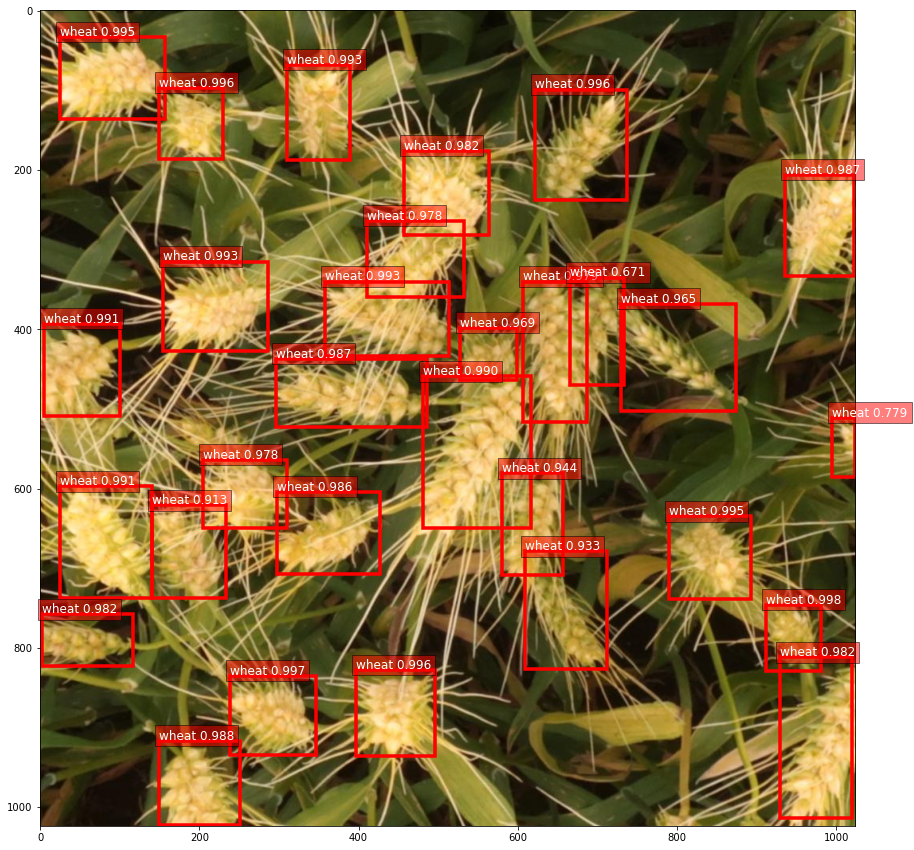

In [22]:
img_filename = "53f253011.jpg"
root = "/kaggle/input/global-wheat-detection/test"
img_path = os.path.join(root, img_filename)
x, orig_img = gcv.data.transforms.presets.rcnn.load_test(img_path, short=img_resize, max_size=img_resize)
#x = mx.nd.zeros(shape=(1, 3, 300, 300)).as_in_context(mx.gpu(0))
class_IDs, scores, bounding_boxes = net(x.as_in_context(mx.gpu(0)))
ax = utils.viz.plot_bbox(orig_img, bounding_boxes[0], scores[0],
                         class_IDs[0], class_names=net.classes)

plt.show()

In [23]:
#net.export("mxnet_faster_rcnn101", epoch=num_epochs)